In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# Help with this notebook and other notebooks came from kaggle
#https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch
#https://www.kaggle.com/code/arkhanzada/eeg-brain-signals-emotion-classification
#https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'deeplearning:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4654608%2F7920775%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240328%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240328T055757Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7d24e50e4bd7325b94a29a4b1c772daa55d03eb3f6fec2395b9d82185aad67731f2793df538a8c866fe8ce86df8ec45ee63d9429bae4bfe09e276d4b4a6466cbde03aff2bc0a0a9f1443132c8c778d562e6605637e58e12bc8153d31f4e002702f4f7b768e3296d4c5b6121d7adfd7de990b79f0cedf8de8db4f4444fc916fb7710f6590bcea1b966c05868a6369b2c6ae9125fe73f1b87069db66f4fb5f9a5ade0d017f88ba0895bf9d5f87181a288d8bfde92f6ca0101299c153dff9e62b4a08c886226759f19156a07c61d6374ed8404be0551cfc70270e1478f52b7c2f09a8baae71b5c93718f45dd65e567eaaace7ae5dbe15c3a2d6fa768f9dd149c306'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Help with this notebook and other notebooks came from kaggle
#https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch
#https://www.kaggle.com/code/arkhanzada/eeg-brain-signals-emotion-classification
#https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as scio
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
try:
    import mne
    print("mne is already installed")
except ModuleNotFoundError:
    !pip install mne
try:
    import ipywidgets
    print("ipywidgets is already installed")
except ModuleNotFoundError:
    !pip install ipywidgets
from ipywidgets import interact, widgets
from scipy.signal import welch
import pandas as pd

try:
    import torch
    print("Torch already installed")
except ModuleNotFoudError:
    !pip install --force-reinstall torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix  # Import confusion_matrix from sklearn


/kaggle/input/deeplearning/dataset_WL_CW_Y.npy
/kaggle/input/deeplearning/dataset_WL_CW_X.npy
mne is already installed
ipywidgets is already installed
Torch already installed


In [ ]:
#Load data in
file_path = '/kaggle/input/deeplearning/dataset_WL_CW_X.npy'
file_path = '/kaggle/input/deeplearning/dataset_WL_CW_Y.npy'


X = np.load('/kaggle/input/deeplearning/dataset_WL_CW_X.npy')
X2 = np.load('/kaggle/input/deeplearning/dataset_WL_CW_X.npy')
label = np.load('/kaggle/input/deeplearning/dataset_WL_CW_Y.npy')
label2 = np.load('/kaggle/input/deeplearning/dataset_WL_CW_Y.npy')
print(X.shape)
print(label.shape)
print(label)



if label2.shape[0] != 2:
  label2 = np.zeros((2, 360))
  label2[0, :] = label[0, :]
  label2[1, :] = 1 - label[0, :]
  print(label2[:, :15])
  print(label2.shape)
else:
  print("Label already changed \n",label2.shape, "\n",label2[:, :312])

(62, 512, 360)
(1, 360)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
(2, 360)


In [ ]:
import numpy as np
from scipy import stats


class EEGFeatureExtractor:
    """
    Extracts time-domain and connectivity features from multi-channel EEG data.
    """

    def __init__(self):
        """
        Initializes feature names.
        """
        self.feature_names = [
            "Mean",
            "Standard deviation",
            "Skewness",
            "Kurtosis",
            "Mean upper triangle correlation",
        ]

    def get_time_domain_features(self, X, sample_idx):
        """
        Calculates time-domain features for each channel in a given EEG sample.

        Args:
            X (np.ndarray): A 3D NumPy array of shape (channels, time_points, samples) representing the EEG data.
            sample_idx (int): Index of the sample for which to calculate features.

        Returns:
            np.ndarray: A 2D NumPy array of shape (channels, 4) containing the calculated features for each channel.
        """

        features = np.zeros((X.shape[0], 4))
        sample_data = X[:, :, sample_idx]

        for channel_idx in range(X.shape[0]):
            channel_data = sample_data[channel_idx, :]
            features[channel_idx, 0] = np.mean(channel_data)  # Mean
            features[channel_idx, 1] = np.std(channel_data)  # Standard deviation
            features[channel_idx, 2] = stats.skew(channel_data)  # Skewness
            features[channel_idx, 3] = stats.kurtosis(channel_data)  # Kurtosis

        return features

    def get_connectivity_features(self, X, sample_idx):
        """
        Calculates connectivity features for a given EEG sample.

        Args:
            X (np.ndarray): A 3D NumPy array of shape (channels, time_points, samples) representing the EEG data.
            sample_idx (int): Index of the sample for which to calculate features.

        Returns:
            np.ndarray: A 1D NumPy array of shape (channels,) containing the mean upper triangle correlation for each channel.
        """

        sample_data = X[:, :, sample_idx]
        corr_matrix = np.corrcoef(sample_data)

        if not hasattr(np, 'triu_indices_n'):
            def triu_indices_n(n, k=0):
                m = n - k
                return np.triu_indices(n, k=k), np.triu_indices(m, k=k)

        if hasattr(np, 'triu_indices_n'):
            corr_triu = corr_matrix[np.triu_indices_n(X.shape[0], k=1)]  # Extract upper triangle (efficiently for newer NumPy)
        else:
            corr_triu = corr_matrix[np.triu_indices(X.shape[0], k=1)[0]]  # Extract upper triangle (compatible with older NumPy)

        # Handle potential division by zero
        if np.all(corr_triu == corr_triu[0]):
            corr_triu = np.ones_like(corr_triu)

        # Reshape and calculate mean across the second dimension
        corr_triu = corr_triu.reshape(62, -1).mean(axis=1)
        return corr_triu

    def calculate_features(self, X):
        """
        Orchestrates the calculation of both time-domain and connectivity features.

        Args:
            X (np.ndarray): EEG data in a 3D array (channels, time_points, samples).

        Returns:
            np.ndarray: Extracted features organized as (channels, features_per_channel, samples).
        """

        features = np.zeros((X.shape[0], len(self.feature_names), X.shape[2]))

        for sample_idx in range(X.shape[2]):
            # Efficiently leverage individual feature extraction functions:
            time_domain_features = self.get_time_domain_features(X, sample_idx)
            connectivity_features = self.get_connectivity_features(X, sample_idx)

            # Combine features into a cohesive output array:
            features[:, :4, sample_idx] = time_domain_features  # Assign time-domain features
            features[:, 4, sample_idx] = connectivity_features  # Assign connectivity feature

        return features

    def get_feature_names(self):
        """
        Returns the list of feature names in the order they appear in the output.
        """
        return self.feature_names



#Use from X2 or X
extractor = EEGFeatureExtractor()
features = extractor.calculate_features(X2)
feature_names = extractor.get_feature_names()

#print("Feature names:", feature_names)
print(features.shape)
print(feature_names,"\n", features[:5, :, 0])  # Print all features for the first sample

(62, 5, 360)
['Mean', 'Standard deviation', 'Skewness', 'Kurtosis', 'Mean upper triangle correlation'] 
 [[ 1.77070343 10.91615582  0.19657676 -0.07511581  0.58574443]
 [ 0.54546785 11.20091057  0.15481508 -0.20793333  0.58531177]
 [-1.64428246 16.36531067 -0.2433497  -0.11014821  0.66535506]
 [ 3.79236603 15.1456461  -0.18992012  0.12326339  0.65949174]
 [-0.9406004  11.10280037  0.4340974   0.0637624   0.49331928]]


# LSTM w/o Preprocessing

(62, 512, 360)
(360, 2)
X_data:  torch.Size([62, 512, 360])
y_data:  torch.Size([360, 2])
Epoch: 1, Train Loss: 0.4832, Val Loss: 0.4552, Train Acc: 0.5104, Val Acc: 0.6250
Epoch: 2, Train Loss: 0.4318, Val Loss: 0.4134, Train Acc: 0.5660, Val Acc: 0.6250
Epoch: 3, Train Loss: 0.3885, Val Loss: 0.3723, Train Acc: 0.6285, Val Acc: 0.6250
Epoch: 4, Train Loss: 0.3488, Val Loss: 0.3361, Train Acc: 0.6910, Val Acc: 0.6806
Epoch: 5, Train Loss: 0.3119, Val Loss: 0.3021, Train Acc: 0.7257, Val Acc: 0.6806
Epoch: 6, Train Loss: 0.2785, Val Loss: 0.2743, Train Acc: 0.7361, Val Acc: 0.6667
Epoch: 7, Train Loss: 0.2525, Val Loss: 0.2572, Train Acc: 0.7708, Val Acc: 0.6528
Epoch: 8, Train Loss: 0.2347, Val Loss: 0.2513, Train Acc: 0.8021, Val Acc: 0.6528
Epoch: 9, Train Loss: 0.2226, Val Loss: 0.2452, Train Acc: 0.8160, Val Acc: 0.6528
Epoch: 10, Train Loss: 0.2107, Val Loss: 0.2394, Train Acc: 0.8264, Val Acc: 0.6667
Epoch: 11, Train Loss: 0.1982, Val Loss: 0.2335, Train Acc: 0.8438, Val Acc: 0.

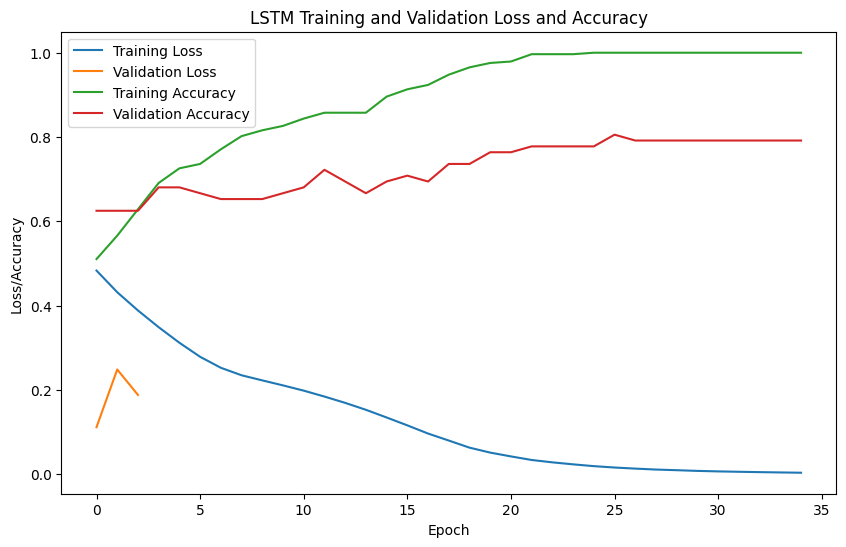

In [ ]:
X_data = X2.copy()
print(X_data.shape)
y_data = label2.copy().T
print(y_data.shape)

# Convert data to PyTorch tensors
X_data = torch.from_numpy(X_data).float()
print("X_data: ", X_data.shape)
y_data = torch.from_numpy(y_data).float()
print("y_data: ", y_data.shape)

# Reshape X_data for time series format (samples, time_steps, channels)
X_data = X_data.permute(2, 1, 0)  # (360, 512, 62)

# Create a PyTorch dataset
dataset = TensorDataset(X_data, y_data)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Get the output from the last time step
        out = self.fc(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_data.shape[-1]  # 62
hidden_size = 128
num_layers = 2
output_size = y_data.shape[1]  # 2
model = LSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 100
patience = 16
best_val_loss = float('inf')
train_losses = []  # Store training losses
val_losses = []  # Store validation losses
train_accuracies = []  # Store training accuracies
val_accuracies = []  # Store validation accuracies
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_correct = 0
    val_correct = 0
    train_total = 0
    val_total = 0

    # Training
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        labels = torch.argmax(labels, dim=1)  # Convert one-hot labels to indices
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Validation
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            labels = torch.argmax(labels, dim=1)  # Convert one-hot labels to indices
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average losses and accuracies for the epoch
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_accuracy = train_correct / train_total
    val_accuracy = val_correct / val_total

    # Store losses and accuracies for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print statistics
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Prediction and accuracy calculation (modified for loss plotting)
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    val_losses = []  # Store validation losses
    predicted_values = []  # Store predicted values
    true_values = []  # Store true values
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_losses.append(loss.item())  # Store loss for plotting

        _, predicted = torch.max(outputs.data, 1)
        labels = torch.argmax(labels, dim=1)  # Convert one-hot labels to indices
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predicted_values.extend(predicted.cpu().numpy())
        true_values.extend(labels.cpu().numpy())

    accuracy = total_correct / total_samples
    print(f"Accuracy on validation set: {accuracy:.4f}")

# Plotting code
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.title('LSTM Training and Validation Loss and Accuracy')
plt.legend()
plt.show()



